### Imports and basic functions

In [1]:
import numpy as np
from skimage.morphology import erosion, dilation, binary_erosion, opening, closing, white_tophat, reconstruction, black_tophat, skeletonize, convex_hull_image, thin, remove_small_objects
from skimage.morphology import square, diamond, octagon, rectangle, star, disk
from skimage.filters.rank import entropy, enhance_contrast_percentile
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte
import math
from skimage import data, filters
from matplotlib import pyplot as plt
from skimage import io, filters, feature, segmentation, morphology, measure, img_as_float, color, exposure
#!pip install -U scikit-image
from skimage.filters import gabor
from skimage.color import rgb2gray
import cv2
import numpy as np
import pandas as pd

def evaluate(img_out, img_GT):
    GT_skel  = thin(img_GT, max_num_iter = 15) # On suppose que la demie epaisseur maximum 
    img_out_skel  = thin(img_out, max_num_iter = 15) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel


def my_segmentation_gabor(img, img_mask, seuil):

    # Convertir l'image en niveaux de gris
    img_gray = rgb2gray(img)

    # Appliquer un filtre de Gabor pour extraire les caractéristiques de texture
    filt_real, filt_imag = gabor(img_gray, frequency=0.06)#gabor_filter(img_gray, frequency=0.6) #

    # Calculer l'amplitude des filtres de Gabor
    filt_amp = np.sqrt(filt_real**2 + filt_imag**2)

    # Appliquer un seuillage sur l'amplitude des filtres de Gabor pour séparer les vaisseaux sanguins
    thresh = filters.threshold_otsu(filt_amp)
    img_vessels = filt_amp > thresh

    # Appliquer une ouverture morphologique pour supprimer les petites structures
    #img_vessels = morphology.opening(img_vessels, morphology.disk(3))

    # Appliquer une fermeture morphologique pour améliorer la connectivité des vaisseaux sanguins
    #img_vessels = morphology.closing(img_vessels, morphology.disk(3))

    # Appliquer une segmentation basée sur la région de croissance pour identifier les vaisseaux sanguins
    img_labels = segmentation.flood(img_vessels, (0, 0), connectivity=1)
    img_out = (img_mask & (img_labels < seuil))
    return img_out



### Data path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/images_tp2/images_IOSTAR/'
file_name = 'star01_OSC.jpg'
file_path = path + file_name

#### Approch 1: meijering and remove_small_objects

##### grid search 

In [4]:
# Test with meijering and connectivity
img = cv2.imread(file_path, cv2.IMREAD_COLOR)
# OpenCV 2 reads images in BGR, so we convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img.astype(np.uint8))
gray_image = img_as_float(color.rgb2gray(image))

best_accu = 0
best_recall = 0
best_hat_size = 0
best_closing_size = 0
best_filter_sigma = 0
best_filter_threshold = 0
best_object_connectivity = 0

for hat_size in np.arange(5, 7, 0.5):
  for closing_size in np.arange(2, 4, 0.5):
    for filter_sigma in np.arange(0.3, 0.7, 0.1):
      for filter_threshold in np.arange(0.09, 0.12, 0.01):
        for object_connectivity in np.arange(1, 5, 1):
          # Perform black tophat transformation
          image_hat = black_tophat(gray_image, footprint=disk(hat_size)) 

          # Perform closing operation
          image_closing = closing(image_hat, footprint=disk(closing_size))

          # Apply the meijering filter for each scale
          filtered_image = filters.meijering(image_closing, sigmas=range(1, 5), black_ridges=False)

          # Apply a Gaussian filter to the filtered image to remove noise
          filtered_image = filters.gaussian(filtered_image, sigma=filter_sigma)

          # Threshold the filtered image to obtain the binary segmentation
          filtered_image = filtered_image > filter_threshold

          # connectivity
          clean_image = remove_small_objects(filtered_image, connectivity=object_connectivity)
          image_final = dilation(clean_image, footprint=disk(1))

          # Convert to boolean
          img_out =image_final.astype(np.bool_)

          # Load ground truth image and convert to boolean
          img_GT = np.asarray(Image.open('/content/drive/MyDrive/images_tp2/images_IOSTAR/GT_01.png')).astype(np.bool_)

          # Evaluate accuracy and recall
          ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)

          # Update best parameters
          if (ACCU + RECALL) / 2 > (best_accu + best_recall) / 2:
              best_accu = ACCU
              best_recall = RECALL
              best_hat_size = hat_size
              best_closing_size = closing_size
              best_filter_sigma = filter_sigma
              best_filter_threshold = filter_threshold
              best_object_connectivity = object_connectivity
print("Accuracy: ", best_accu)
print("Recall: ", best_recall)
print("Hat size for black tophat: ", best_hat_size)
print("Disk size for closing: ", best_closing_size)
print("Sigma value for denoising: ", best_filter_sigma)
print("Threshold for filter: ", best_filter_threshold)
print("Connectivity for remove small objects: ", best_object_connectivity)
print("===============================================================")

Accuracy:  0.8000878734622144
Recall:  0.734718579786161
Hat size for black tophat:  6.5
Disk size for closing:  3.5
Sigma value for denoising:  0.6000000000000001
Threshold for filter:  0.10999999999999999
Connectivity for remove small objects:  1


##### final results

Accuray:  0.8000878734622144 Recall:  0.734718579786161
Average score:  0.7674032266241877


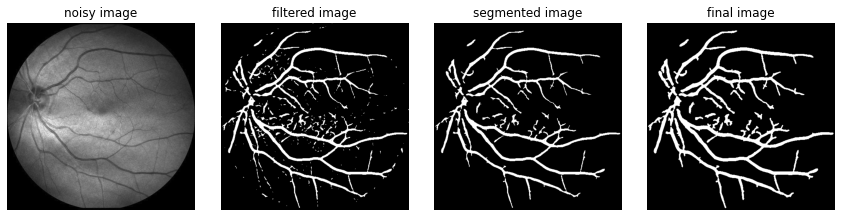

In [5]:
# Test with meijering and connectivity
img = cv2.imread(file_path, cv2.IMREAD_COLOR)
# OpenCV 2 reads images in BGR, so we convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img.astype(np.uint8))
gray_image = img_as_float(color.rgb2gray(image))

# Perform black tophat transformation
image_hat = black_tophat(gray_image, footprint=disk(6.5)) 

# Perform closing operation
image_closing = closing(image_hat, footprint=disk(3.5))

# Apply the meijering filter for each scale
filtered_image = filters.meijering(image_closing, sigmas=range(1, 5), black_ridges=False)

# Apply a Gaussian filter to the filtered image to remove noise
filtered_image = filters.gaussian(filtered_image, sigma=0.6)

# Threshold the filtered image to obtain the binary segmentation
filtered_image = filtered_image > 0.11

# connectivity
clean_image = remove_small_objects(filtered_image, connectivity=1)
image_final = dilation(clean_image, footprint=disk(1))

# Convert to boolean
img_out =image_final.astype(np.bool_)

# Load ground truth image and convert to boolean
img_GT = np.asarray(Image.open('/content/drive/MyDrive/images_tp2/images_IOSTAR/GT_01.png')).astype(np.bool_)

# Evaluate accuracy and recall
ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
print('Accuray: ', ACCU, 'Recall: ', RECALL)
print('Average score: ', (ACCU + RECALL) / 2)

# display results
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('noisy image', fontsize=12)

ax[1].imshow(filtered_image, cmap='gray')
ax[1].set_title('filtered image', fontsize=12)

ax[2].imshow(clean_image, cmap='gray')
ax[2].set_title('segmented image', fontsize=12)

ax[3].imshow(image_final, cmap='gray')
ax[3].set_title('final image', fontsize=12)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

#### Approach 2: meijering, Label and local_maxima

##### Grid search

In [6]:
# Test with meijering and connectivity
img = cv2.imread(file_path, cv2.IMREAD_COLOR)
# OpenCV 2 reads images in BGR, so we convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img.astype(np.uint8))
gray_image = img_as_float(color.rgb2gray(image))

best_accu = 0
best_recall = 0
best_hat_size = 0
best_closing_size = 0
best_filter_sigma = 0
best_filter_threshold = 0
best_object_connectivity = 0

for hat_size in np.arange(5, 7, 0.5):
  for closing_size in np.arange(2, 4, 0.5):
    for filter_sigma in np.arange(0.3, 0.7, 0.1):
      for filter_threshold in np.arange(0.09, 0.15, 0.01):
        for object_connectivity in np.arange(1, 10, 1):
          # Perform black tophat transformation
          image_hat = black_tophat(gray_image, footprint=disk(hat_size)) 

          # Perform closing operation
          image_closing = closing(image_hat, footprint=disk(closing_size))

          # Apply the meijering filter for each scale
          filtered_image = filters.meijering(image_closing, sigmas=range(1, 5), black_ridges=False)

          # Apply a Gaussian filter to the filtered image to remove noise
          filtered_image = filters.gaussian(filtered_image, sigma=filter_sigma)

          # Threshold the filtered image to obtain the binary segmentation
          filtered_image = filtered_image > filter_threshold

          # We find all local maxima
          enhanced_image = exposure.rescale_intensity(filtered_image)
          local_maxima = morphology.local_maxima(enhanced_image)
          label_maxima = morphology.label(local_maxima)
          overlay = color.label2rgb(label_maxima, gray_image, alpha=0.7, bg_label=0,
                                    bg_color=None, colors=[(1, 0, 0)])

          clean_image = remove_small_objects(local_maxima, connectivity=object_connectivity)
          image_final = dilation(clean_image, footprint=disk(2))

          # Convert to boolean
          img_out = image_final.astype(np.bool_)

          # Load ground truth image and convert to boolean
          img_GT = np.asarray(Image.open('/content/drive/MyDrive/images_tp2/images_IOSTAR/GT_01.png')).astype(np.bool_)

          # Evaluate accuracy and recall
          ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)

# Update best parameters
          if (ACCU + RECALL) / 2 > (best_accu + best_recall) / 2:
              best_accu = ACCU
              best_recall = RECALL
              best_hat_size = hat_size
              best_closing_size = closing_size
              best_filter_sigma = filter_sigma
              best_filter_threshold = filter_threshold
              best_object_connectivity = object_connectivity
print("Accuracy: ", best_accu)
print("Recall: ", best_recall)
print("Hat size for black tophat: ", best_hat_size)
print("Disk size for closing: ", best_closing_size)
print("Sigma value for denoising: ", best_filter_sigma)
print("Threshold for filter: ", best_filter_threshold)
print("Connectivity for remove small objects: ", best_object_connectivity)
print("===============================================================")

Accuracy:  0.872237744475489
Recall:  0.6976838683462008
Hat size for black tophat:  5.5
Disk size for closing:  2.5
Sigma value for denoising:  0.5
Threshold for filter:  0.12999999999999998
Connectivity for remove small objects:  1


Accuray:  0.872237744475489 Recall:  0.6976838683462008
Average score:  0.7849608064108449


(-0.5, 511.5, 511.5, -0.5)

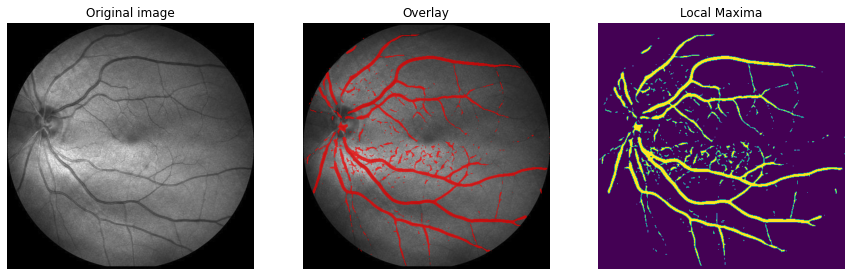

In [19]:
# Test with meijering filter, label and local_maxima

img = cv2.imread(file_path, cv2.IMREAD_COLOR)
# OpenCV 2 reads images in BGR, so we convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img.astype(np.uint8))
gray_image = img_as_float(color.rgb2gray(image))

# Perform black tophat transformation
image_hat = black_tophat(gray_image, footprint=disk(5.5)) 

# Perform closing operation
image_closing = closing(image_hat, footprint=disk(2.5))

# Apply the meijering filter for each scale
filtered_image = filters.meijering(image_closing, sigmas=range(1, 5), black_ridges=False)

# Apply a Gaussian filter to the filtered image to remove noise
filtered_image = filters.gaussian(filtered_image, sigma=0.5)

# Threshold the filtered image to obtain the binary segmentation
filtered_image = filtered_image > 0.13

# We find all local maxima
enhanced_image = exposure.rescale_intensity(filtered_image)
local_maxima = morphology.local_maxima(enhanced_image)
label_maxima = morphology.label(local_maxima)
overlay = color.label2rgb(label_maxima, gray_image, alpha=0.7, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])

clean_image = remove_small_objects(local_maxima, connectivity=1)
image_final = dilation(clean_image, footprint=disk(2))

# Convert to boolean
img_out = image_final.astype(np.bool_)

# Load ground truth image and convert to boolean
img_GT = np.asarray(Image.open('/content/drive/MyDrive/images_tp2/images_IOSTAR/GT_01.png')).astype(np.bool_)

# Evaluate accuracy and recall
ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
print('Accuray: ', ACCU, 'Recall: ', RECALL)
print('Average score: ', (ACCU + RECALL) / 2)


# a new figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(overlay)
ax[1].set_title('Overlay')
ax[1].axis('off')

ax[2].imshow(local_maxima)
ax[2].set_title('Local Maxima')
ax[2].axis('off')


#### Approach 3: Entropy + white tophat

<ipython-input-8-96e05e7ea341>:9: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  ax.imshow(entropy(img_closing, disk(radi[n])), cmap =


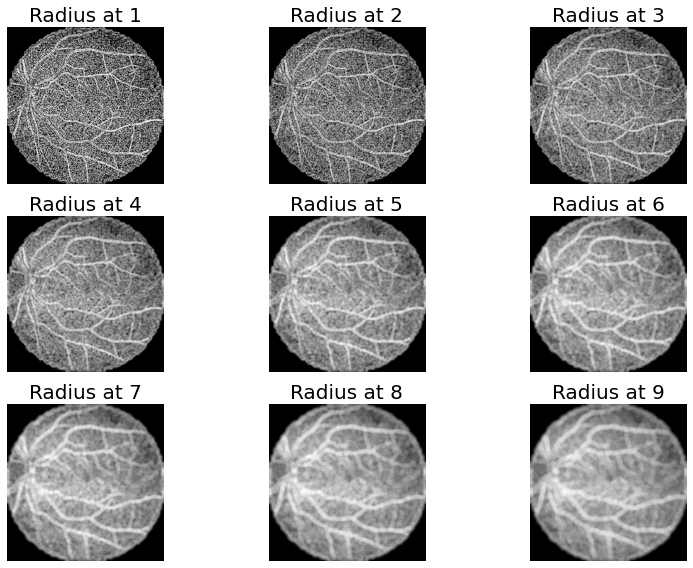

In [8]:
def disk_iterations(img):
    gray_img = color.rgb2gray(img)
    img_hat = black_tophat(gray_img, footprint=disk(4))
    img_closing = closing(img_hat, footprint=disk(2))
    radi = list(range(1,10))
    fig, ax = plt.subplots(3,3,figsize=(12,8))
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(f'Radius at {radi[n]}', fontsize = 20)
        ax.imshow(entropy(img_closing, disk(radi[n])), cmap = 
                  'gray');
        ax.set_axis_off()
    fig.tight_layout()


img = cv2.imread(file_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img.astype(np.uint8))
gray_image = img_as_float(color.rgb2gray(image))

disk_iterations(image)


<ipython-input-9-002861b66a3f>:6: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_img = entropy(img_closing, disk(2))


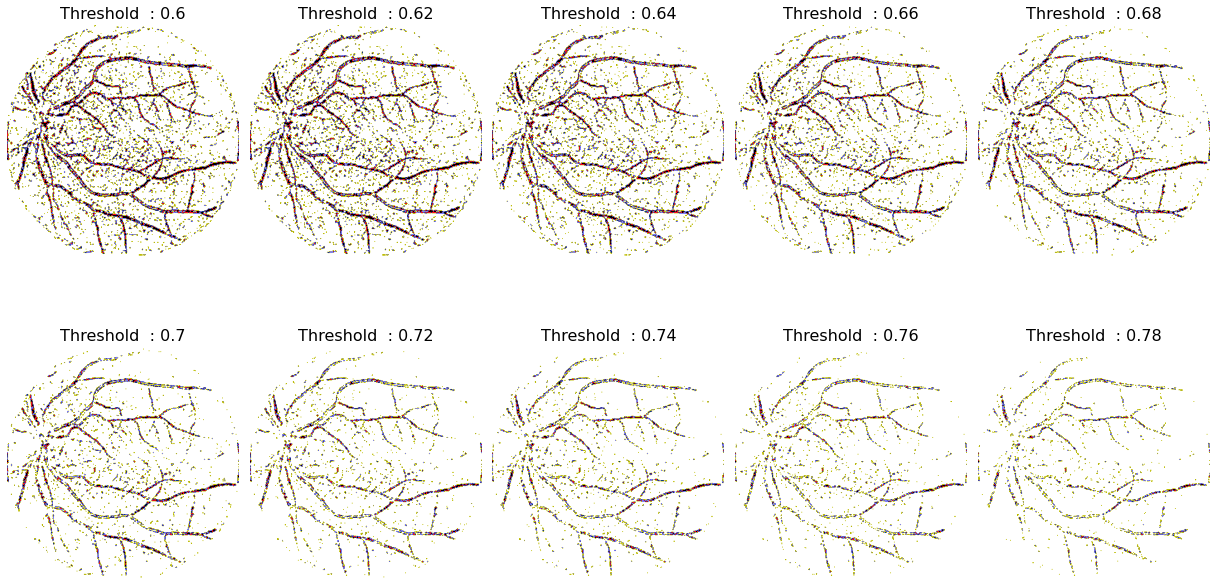

In [9]:
def threshold_checker(img):
    thresholds =  np.arange(0.6,0.82,0.02)
    gray_img = color.rgb2gray(img)
    img_hat = black_tophat(gray_img, footprint=disk(4))
    img_closing = closing(img_hat, footprint=disk(3))
    entropy_img = entropy(img_closing, disk(2))
    scaled_entropy = entropy_img / entropy_img.max()  
    fig, ax = plt.subplots(2, 5, figsize=(17, 10))
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(f'Threshold  : {round(thresholds[n],2)}', 
                     fontsize = 16)
        threshold =  scaled_entropy > thresholds[n] 
        clean_image = remove_small_objects(threshold, connectivity=8)
        image_final = dilation(clean_image, footprint=disk(2))
        ax.imshow(threshold, cmap = 'gist_stern_r') ;
        ax.axis('off')
    fig.tight_layout()

threshold_checker(image)

<ipython-input-10-22735213c6bc>:5: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_img = entropy(img_closing, disk(2))


Accuray:  0.6732047333441401 Recall:  0.7542680711950599
Average score:  0.7137364022696


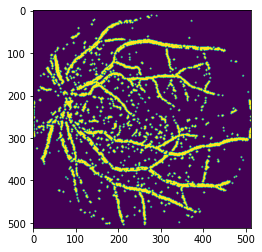

In [10]:
def entropy_segmentation(img):
  gray_img = color.rgb2gray(img)
  img_hat = black_tophat(gray_img, footprint=disk(4))
  img_closing = closing(img_hat, footprint=disk(3))
  entropy_img = entropy(img_closing, disk(2))
  scaled_entropy = entropy_img / entropy_img.max()  
  threshold =  scaled_entropy > 0.74 
  clean_image = remove_small_objects(threshold, connectivity=4)
  image_final = dilation(threshold, disk(2))
  return threshold, image_final

threshold, image_final = entropy_segmentation(image)
plt.imshow(image_final)

# Convert to boolean
img_out = image_final.astype(np.bool_)

# Load ground truth image and convert to boolean
img_GT = np.asarray(Image.open('/content/drive/MyDrive/images_tp2/images_IOSTAR/GT_01.png')).astype(np.bool_)

# Evaluate accuracy and recall
ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
print('Accuray: ', ACCU, 'Recall: ', RECALL)
print('Average score: ', (ACCU + RECALL) / 2)

##### Grid search

In [11]:
img = cv2.imread(file_path, cv2.IMREAD_COLOR)
# OpenCV 2 reads images in BGR, so we convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img.astype(np.uint8))
gray_image = img_as_float(color.rgb2gray(image))

best_accu = 0
best_recall = 0
best_hat_size = 0
best_closing_size = 0
best_filter_sigma = 0
best_filter_threshold = 0
best_object_connectivity = 0

for hat_size in np.arange(5, 7, 0.5):
  for closing_size in np.arange(2, 4, 0.5):
    for entropy_size in np.arange(1, 4, 1):
      for filter_threshold in np.arange(0.5, 0.9, 0.05):
        for object_connectivity in np.arange(1, 10, 1):
          image_hat = black_tophat(gray_image, footprint=disk(hat_size))
          image_closing = closing(image_hat, footprint=disk(closing_size))
          entropy_image = entropy(image_closing, disk(entropy_size))
          scaled_entropy = entropy_image / entropy_image.max()  
          threshold =  scaled_entropy > filter_threshold
          clean_image = remove_small_objects(threshold, connectivity=object_connectivity)
          image_final = dilation(threshold, disk(2))

          # Convert to boolean
          img_out = image_final.astype(np.bool_)

          # Load ground truth image and convert to boolean
          img_GT = np.asarray(Image.open('/content/drive/MyDrive/images_tp2/images_IOSTAR/GT_01.png')).astype(np.bool_)

          # Evaluate accuracy and recall
          ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)

# Update best parameters
          if (ACCU + RECALL) / 2 > (best_accu + best_recall) / 2:
              best_accu = ACCU
              best_recall = RECALL
              best_hat_size = hat_size
              best_closing_size = closing_size
              best_entropy_size = entropy_size
              best_filter_threshold = filter_threshold
              best_object_connectivity = object_connectivity
print("Accuracy: ", best_accu)
print("Recall: ", best_recall)
print("Hat size for black tophat: ", best_hat_size)
print("Disk size for closing: ", best_closing_size)
print("Disk size for entropy: ", best_entropy_size)
print("Threshold for filter: ", best_filter_threshold)
print("Connectivity for remove small objects: ", best_object_connectivity)
print("===============================================================")

<ipython-input-11-722b84b36885>:22: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_image = entropy(image_closing, disk(entropy_size))


Accuracy:  0.6809260191243081
Recall:  0.810341385506089
Hat size for black tophat:  6.5
Disk size for closing:  3.0
Disk size for entropy:  3
Threshold for filter:  0.6500000000000001
Connectivity for remove small objects:  1


### Evalution with chosen approach

In [12]:
def my_seg_1(segmentation_path, evaluation_path):
  img = cv2.imread(segmentation_path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image = Image.fromarray(img.astype(np.uint8))
  gray_image = img_as_float(color.rgb2gray(image))

  # Perform black tophat transformation
  image_hat = black_tophat(gray_image, footprint=disk(6.5)) 

  # Perform closing operation
  image_closing = closing(image_hat, footprint=disk(3.5))

  # Apply the meijering filter for each scale
  filtered_image = filters.meijering(image_closing, sigmas=range(1, 5), black_ridges=False)

  # Apply a Gaussian filter to the filtered image to remove noise
  filtered_image = filters.gaussian(filtered_image, sigma=0.6)

  # Threshold the filtered image to obtain the binary segmentation
  filtered_image = filtered_image > 0.11

  # Remove small objects with connectivity parameter
  clean_image = remove_small_objects(filtered_image, connectivity=1)
  image_final = dilation(clean_image, footprint=disk(1))

  # Convert to boolean
  img_out = image_final.astype(np.bool_)

  # Load ground truth image and convert to boolean
  img_GT = np.asarray(Image.open(evaluation_path)).astype(np.bool_)

  # Evaluate accuracy and recall
  ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)

  return img_out, ACCU, RECALL

  

In [13]:
# List of filenames 
list_to_eval = ['GT_01.png', 'GT_02.png', 'GT_03.png', 'GT_08.png' , 'GT_21.png', 'GT_26.png', 'GT_28.png', 'GT_32.png' ,  'GT_37.png', 'GT_48.png']
list_to_seg = ['star01_OSC.jpg', 'star02_OSC.jpg', 'star03_OSN.jpg', 'star08_OSN.jpg', 'star21_OSC.jpg', 'star26_ODC.jpg', 'star28_ODN.jpg', 'star32_ODC.jpg', 'star37_ODN.jpg', 'star48_OSN.jpg'] 

In [14]:
# create an empty DataFrame to store the results
results_df = pd.DataFrame() 

names = []
accs =[]
recs = []

for i in range(len(list_to_eval)):
    img_out, ACCU, RECALL = my_seg_1(path + list_to_seg[i], path + list_to_eval[i])
    
    # append the results to the DataFrame
    names.append(list_to_seg[i])
    accs.append(ACCU)
    recs.append(RECALL)
names = np.array(names)
accs = np.array(accs)
recs = np.array(recs)

print("Average accuracy",np.mean(accs),"\n")
print("Average recall",np.mean(recs),"\n")


results_df['Filename'] = pd.Series(names) 
results_df['Accuracy'] = pd.Series(accs)    
results_df['Recall'] = pd.Series(recs)    

results_df

Average accuracy 0.7644400636021584 

Average recall 0.7027970036412335 



,Filename,Accuracy,Recall
0,star01_OSC.jpg,0.800088,0.734719
1,star02_OSC.jpg,0.756847,0.803379
2,star03_OSN.jpg,0.746822,0.695457
3,star08_OSN.jpg,0.841513,0.715953
4,star21_OSC.jpg,0.696779,0.624314
5,star26_ODC.jpg,0.760746,0.616273
6,star28_ODN.jpg,0.721548,0.639638
7,star32_ODC.jpg,0.759427,0.715250
8,star37_ODN.jpg,0.820032,0.710706
9,star48_OSN.jpg,0.740598,0.772282


In [15]:
def my_seg_2(segmentation_path, evaluation_path):
  img = cv2.imread(segmentation_path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image = Image.fromarray(img.astype(np.uint8))
  gray_image = img_as_float(color.rgb2gray(image))

  # Perform black tophat transformation
  image_hat = black_tophat(gray_image, footprint=disk(5.5)) 

  # Perform closing operation
  image_closing = closing(image_hat, footprint=disk(2.5))

  # Apply the meijering filter for each scale
  filtered_image = filters.meijering(image_closing, sigmas=range(1, 5), black_ridges=False)

  # Apply a Gaussian filter to the filtered image to remove noise
  filtered_image = filters.gaussian(filtered_image, sigma=0.5)

  # Threshold the filtered image to obtain the binary segmentation
  filtered_image = filtered_image > 0.13

  # We find all local maxima
  enhanced_image = exposure.rescale_intensity(filtered_image)
  local_maxima = morphology.local_maxima(enhanced_image)
  label_maxima = measure.label(local_maxima)
  overlay = color.label2rgb(label_maxima, gray_image, alpha=0.7, bg_label=0,
                            bg_color=None, colors=[(1, 0, 0)])

  clean_image = remove_small_objects(local_maxima, connectivity=1)
  image_final = dilation(clean_image, footprint=disk(2))

  # Convert to boolean
  img_out = image_final.astype(np.bool_)

  # Load ground truth image and convert to boolean
  img_GT = np.asarray(Image.open(evaluation_path)).astype(np.bool_)

  # Evaluate accuracy and recall
  ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)

  return img_out, ACCU, RECALL
    

In [16]:
# create an empty DataFrame to store the results
results_df = pd.DataFrame() 

names = []
accs =[]
recs = []

for i in range(len(list_to_eval)):
    img_out, ACCU, RECALL = my_seg_2(path + list_to_seg[i], path + list_to_eval[i])
    
    # append the results to the DataFrame
    names.append(list_to_seg[i])
    accs.append(ACCU)
    recs.append(RECALL)
names = np.array(names)
accs = np.array(accs)
recs = np.array(recs)

print("Average accuracy",np.mean(accs),"\n")
print("Average recall",np.mean(recs),"\n")


results_df['Filename'] = pd.Series(names) 
results_df['Accuracy'] = pd.Series(accs)    
results_df['Recall'] = pd.Series(recs)    

results_df

Average accuracy 0.818926519250148 

Average recall 0.6768383926618464 



,Filename,Accuracy,Recall
0,star01_OSC.jpg,0.872238,0.697684
1,star02_OSC.jpg,0.805029,0.789896
2,star03_OSN.jpg,0.789162,0.690900
3,star08_OSN.jpg,0.918500,0.674245
4,star21_OSC.jpg,0.766282,0.614685
5,star26_ODC.jpg,0.788758,0.589231
6,star28_ODN.jpg,0.783077,0.581574
7,star32_ODC.jpg,0.803245,0.683357
8,star37_ODN.jpg,0.848061,0.694193
9,star48_OSN.jpg,0.814913,0.752619


In [17]:
def my_seg_3(segmentation_path, evaluation_path):
  img = cv2.imread(segmentation_path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image = Image.fromarray(img.astype(np.uint8))
  gray_image = img_as_float(color.rgb2gray(image))

  image_hat = black_tophat(gray_image, footprint=disk(6.5))
  image_closing = closing(image_hat, footprint=disk(3))
  entropy_image = entropy(image_closing, disk(3))
  scaled_entropy = entropy_image / entropy_image.max()  
  threshold =  scaled_entropy > 0.65
  clean_image = remove_small_objects(threshold, connectivity=1)
  image_final = dilation(threshold, disk(2))

  # Convert to boolean
  img_out = image_final.astype(np.bool_)

  # Load ground truth image and convert to boolean
  img_GT = np.asarray(Image.open(evaluation_path)).astype(np.bool_)

  # Evaluate accuracy and recall
  ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)

  return img_out, ACCU, RECALL

In [18]:
# create an empty DataFrame to store the results
results_df = pd.DataFrame() 

names = []
accs =[]
recs = []

for i in range(len(list_to_eval)):
    img_out, ACCU, RECALL = my_seg_3(path + list_to_seg[i], path + list_to_eval[i])
    
    # append the results to the DataFrame
    names.append(list_to_seg[i])
    accs.append(ACCU)
    recs.append(RECALL)
names = np.array(names)
accs = np.array(accs)
recs = np.array(recs)

print("Average accuracy",np.mean(accs),"\n")
print("Average recall",np.mean(recs),"\n")


results_df['Filename'] = pd.Series(names) 
results_df['Accuracy'] = pd.Series(accs)    
results_df['Recall'] = pd.Series(recs)    

results_df

<ipython-input-17-a6f571478934>:9: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_image = entropy(image_closing, disk(3))


Average accuracy 0.6765472892453817 

Average recall 0.7604364150253262 



,Filename,Accuracy,Recall
0,star01_OSC.jpg,0.680926,0.810341
1,star02_OSC.jpg,0.613204,0.872869
2,star03_OSN.jpg,0.734433,0.698770
3,star08_OSN.jpg,0.755293,0.751656
4,star21_OSC.jpg,0.630657,0.687480
5,star26_ODC.jpg,0.665753,0.699695
6,star28_ODN.jpg,0.665172,0.735179
7,star32_ODC.jpg,0.666898,0.780072
8,star37_ODN.jpg,0.662165,0.765872
9,star48_OSN.jpg,0.690970,0.802432
